In [268]:
import cv2
import os
import random
import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

In [269]:
import copy
import time 

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [270]:
df = pd.read_csv('../input/training/Labels.csv')
#df['labels'] = df['labels'].apply(lambda x: x - 1) #Because Cross entropy takes 0 to N-1 classes
#df.to_csv('labels_updated.csv')
df.head()

,Unnamed: 0,filenames,labels_code,labels
0,0,img001-001.png,img001,0
1,1,img001-002.png,img001,0
2,2,img001-003.png,img001,0
3,3,img001-004.png,img001,0
4,4,img001-007.png,img001,0


In [271]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [272]:

train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.CenterCrop(600),
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize(mean =  [0.49139968, 0.48215841, 0.44653091], 
                                                std = [0.24703223, 0.24348513, 0.26158784])
                       ])

valid_transforms = transforms.Compose([
                           transforms.CenterCrop(600),
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize(mean =  [0.49139968, 0.48215841, 0.44653091], 
                                                std = [0.24703223, 0.24348513, 0.26158784])
                       ])

In [273]:
class mydataset():
    def __init__(self, csv, img_path, transform=None):
        self.labels_df = pd.read_csv(csv)
        self.img_path = img_path
        self.transform = transform
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.img_path, self.labels_df.iloc[index,1])
        img = Image.open(image_path)
        y_label = torch.tensor(int(self.labels_df.iloc[index, 3]))
        
        if self.transform:
            img = self.transform(img)
        return [img, y_label]

In [274]:
LABELS='../input/training/Labels.csv' 
ROOT = '../input/training/train/train/'
VALID_RATIO = 0.9

train_data = mydataset(csv=LABELS, img_path=ROOT, transform = train_transforms)

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,[n_train_examples, n_valid_examples])

In [275]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = valid_transforms

In [276]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 2232
Number of validation examples: 248


In [277]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data,shuffle = True, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

In [278]:
def plot_images(images, labels, classes, normalize = False):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]-1])
        ax.axis('off')

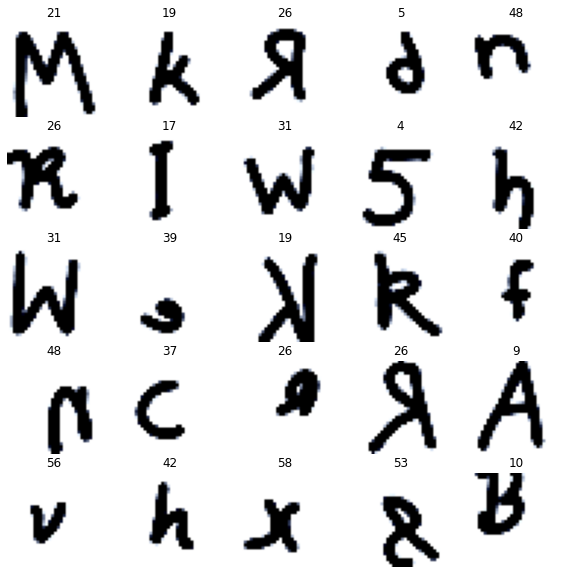

In [279]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = list(df['labels'].unique())
plot_images(images, labels, classes)

In [280]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2), #kernel_size
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [281]:
OUTPUT_DIM = 62
learning_rate = 1e-3
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [282]:
model = AlexNet(OUTPUT_DIM)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [283]:
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_iterator:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()
        
        log_ps, _ = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_iterator:
                images, labels = images.to(device), labels.to(device)
                log_ps, _ = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_iterator))
        test_losses.append(test_loss/len(test_iterator))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_iterator)))

Epoch: 1/30..  Training Loss: 4.134..  Test Loss: 4.126..  Test Accuracy: 0.010
Epoch: 2/30..  Training Loss: 4.076..  Test Loss: 3.917..  Test Accuracy: 0.016
Epoch: 3/30..  Training Loss: 3.808..  Test Loss: 3.762..  Test Accuracy: 0.029
Epoch: 4/30..  Training Loss: 3.532..  Test Loss: 3.399..  Test Accuracy: 0.048
Epoch: 5/30..  Training Loss: 3.285..  Test Loss: 3.210..  Test Accuracy: 0.077
Epoch: 6/30..  Training Loss: 3.112..  Test Loss: 3.079..  Test Accuracy: 0.152
Epoch: 7/30..  Training Loss: 2.929..  Test Loss: 2.967..  Test Accuracy: 0.122
Epoch: 8/30..  Training Loss: 2.729..  Test Loss: 2.803..  Test Accuracy: 0.165
Epoch: 9/30..  Training Loss: 2.601..  Test Loss: 2.500..  Test Accuracy: 0.216
Epoch: 10/30..  Training Loss: 2.404..  Test Loss: 2.385..  Test Accuracy: 0.260
Epoch: 11/30..  Training Loss: 2.267..  Test Loss: 2.284..  Test Accuracy: 0.329
Epoch: 12/30..  Training Loss: 2.125..  Test Loss: 2.116..  Test Accuracy: 0.336
Epoch: 13/30..  Training Loss: 1.945.

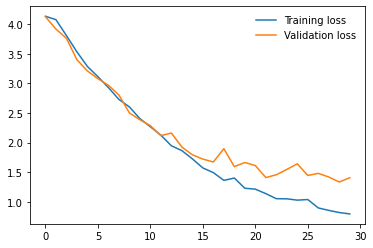

In [284]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [285]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores, _ = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

In [286]:
print("Checking accuracy on Training Set")
check_accuracy(train_iterator, model)

Checking accuracy on Training Set
Got 1781 / 2232 with accuracy 79.79


In [ ]:
#OVERFITTING!